# Simulations of ideal-observer model

Some comments:
If you don't have the `dataset` or the `psycopg2` modules installed, type the following from a command line on your computer:
```
pip install dataset
pip install psycopg2
```

In [51]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
import numpy as np
from scipy.stats import rv_discrete, beta, gamma, norm
from scipy import stats
import scipy
#import random
# import sqlite3
import datetime
# import subprocess
# import scipy.stats
# import psycopg2
# import dataset
# import pandas  # for data frames

In [52]:
def raster(event_times_list, **kwargs):
    """
    Creates a raster plot
    Parameters
    ----------
    event_times_list : iterable
                       a list of event time iterables
    color : string
            color of vlines
    Returns
    -------
    ax : an axis containing the raster plot
    """
    ax = plt.gca()
    for ith, trial in enumerate(event_times_list):
        plt.vlines(trial, ith + .5, ith + 1.5, **kwargs)
    plt.ylim(.5, len(event_times_list) + .5)
    return ax

# Class definition

In [53]:
class Experiment(object):
    def __init__(self, exp_dt, setof_trial_dur, setof_h, tot_trial, states=np.array([-1, 1]),
                 exp_prior=np.array([.5,.5]), setof_low_high_rates=[2,38], 
                 obs_values=['leftclick', 'rightclick', 'noclick'], setof_stim_noise=1):
        self.states = states
        self.setof_stim_noise = setof_stim_noise
        self.setof_trial_dur = setof_trial_dur  # for now an integer in msec.
        self.tot_trial = tot_trial
#         self.outputs = outputs
        self.setof_h = setof_h
        self.results = []
        self.exp_prior = exp_prior  # TODO: check that entries >=0 and sum to 1
        self.setof_low_high_rates = setof_low_high_rates
        self.obs_values = obs_values
        
        # the following decreases slightly dt if it does not divide the trial duration
        T = self.setof_trial_dur
        dt = exp_dt
        Ir = T / dt
        if Ir != round(Ir):
            I = np.ceil(Ir)
            dt = Ir / I * dt
            print('The value of dt has been decreased to ', dt, 'in order to make divide T')
        self.exp_dt = exp_dt  # in sec

    # function that switches the environment state that is given as argument
    def switch(self, H):
        try:
            # might be more elegant to use elseif syntax below
            if H in self.states:
                if H == self.states[0]:
                    return self.states[1]
                else:
                    return self.states[0]
            else:
                raise ValueError("Error in argument H: must be an element of "
                                 "Experiment.states")
        except AttributeError as err:
            print(err.args)

    def launch(self, observer, singleTrialOutputs, multiTrialOutputs):
        # boolean variables telling the script what to plot
        # plots are produced for a single trial ONLY if the total number of trials is 1
        # plots are produced for several trials ONLY if the total number of trials is > 1
        if self.tot_trial == 1:
            printEnvt = singleTrialOutputs[0]
            printStim = singleTrialOutputs[1]
            printLLR = singleTrialOutputs[2]
            multi = False
            raw_perf = False
            perf_lastcp = False
        else:
            printEnvt = False
            printStim = False
            printLLR = False
            multi = True
            raw_perf = multiTrialOutputs[0]
            perf_lastcp = multiTrialOutputs[1]
        
        for trial_idx in range(self.tot_trial):
            h = self.setof_h                    # true hazard rate for current trial
            duration = self.setof_trial_dur     # trial duration in msec
            stim_noise = self.setof_stim_noise  # std dev of stimulus generation conditional probability density
            trial_number = trial_idx
            low_high_rates = self.setof_low_high_rates
            # select initial true environment state for current trial
            if np.random.uniform() < self.exp_prior[0]:
                init_state = self.states[0]
            else:
                init_state = self.states[1]
                
            curr_exp_trial = ExpTrial(self, h, duration, stim_noise,
                                      trial_number, init_state, printEnvt, low_high_rates)
            curr_stim = Stimulus(curr_exp_trial, printStim)
            curr_obs_trial = ObsTrial(curr_exp_trial, curr_stim, observer.dt, self, 
                                      observer.prior_states, observer.prior_h)
            curr_obs_trial.infer(printLLR)
            
            # gather variables to store in database
            if multi:
                trial_duration = curr_exp_trial.duration # in seconds
                cp = curr_exp_trial.cp_times
                if cp.size > 0:
                    time_last_cp = trial_duration - curr_exp_trial.cp_times[-1]
                else:
                    time_last_cp = curr_exp_trial.duration
                dec = int(curr_obs_trial.decision)
                correct = bool(dec == curr_exp_trial.end_state)
                populate_db(cur, trial_idx, dec, correct, time_last_cp, trial_duration)    
    
    def raw_perf(self):
        cursor = cur.execute("SELECT COUNT(Correct) FROM Results WHERE Correct == 1")
        for row in cursor:
            print('percent correct = ', (row[0] / self.tot_trial) * 100)
            print(' ')  # just to have a blank line
        
    def perf_last_cp(self):
#         print('entered the perf_last_cp function')
        cursor1 = cur.execute('''SELECT TimeLastCp, SUM(Correct)*1.0 / COUNT(TimeLastCp), COUNT(TimeLastCp)
                                FROM Results 
                                GROUP BY TimeLastCp
                                ORDER BY TimeLastCp''')
        time = np.zeros(0)
        perf = np.copy(time)
        counts = np.copy(time)
        for row in cursor1:
            time = np.append(time, row[0])
            perf = np.append(perf, row[1])
            counts = np.append(counts, row[2])
#             print(row)
        plt.figure()
        plt.ylim([0,counts.max()])
        plt.bar(time, counts, align='center', width=3)
        plt.title('Histogram of trial counts per time bin')
        plt.xlabel('time since last CP (msec)')
        plt.ylabel('trial count')
        
        plt.figure()
        plt.plot(time, perf)
        plt.title('perf as fcn of time since last CP')
        plt.xlabel('time since last CP (msec)')
        plt.ylabel('percent correct')
        plt.show()
        
    def parallel_launch(self):
        return 0  # temporary

In [54]:
class ExpTrial(object):
    def __init__(self, expt, h, duration, stim_noise, trial_number,
                 init_state, printEnvt, low_high_rates):
        self.expt = expt
        self.true_h = h
        self.duration = duration  # sec
        self.stim_noise = stim_noise
        self.trial_number = trial_number
        self.init_state = init_state
        self.cp_times = self.gen_cp(self.duration, self.true_h, printEnvt)
        self.end_state = self.compute_endstate(len(self.cp_times))
        self.tot_trial = self.expt.tot_trial
        self.low_high_rates = low_high_rates

    def compute_endstate(self, ncp):
        # the fact that the last state equals the initial state depends on
        # the evenness of the number of change points.
        if ncp % 2 == 0:
            return self.init_state
        else:
            return self.expt.switch(self.init_state)

    # the following is the likelihood used to generate stimulus values,
    #  given the true state H of the environment
    def randlh(self, H):
        # try clause might be redundant (because switch method does it)
        try:
            if H in self.expt.states:
                return np.random.normal(H, self.stim_noise)
            else:
                raise ValueError("Error in argument H: must be an element of "
                                 "Experiment.states")
        except ValueError as err:
            print(err.args)

    '''
    generates poisson train of duration milliseconds with rate true_h in Hz, 
    using the Gillespie algorithm.
    
    print statements are only there for debugging purposes
    '''
    def gen_cp(self, duration, true_h, printEnvt):
        # TODO: Generate a warning if >1 ch-pt occur in Experiment.exp_dt window
        # print('launching gen_cp')
        # print('secdur = '), secdur
        '''
        pre-allocate ten times the mean array size 
        for speed, will be shrinked after computation
        '''
        nEntries = int(np.ceil(10 * true_h * duration))
        # print('allocated entries = '), nEntries

        t = np.zeros(nEntries)
        if nEntries == 0:
            print('change point times are')
            print(t)
            return t
            
        totalTime = 0
        eventIdx = -1

        while totalTime < duration:
            sojournTime = np.random.exponential(1. / true_h)
            totalTime += sojournTime
            eventIdx += 1
            t[eventIdx] = totalTime

        # trim unused nodes, and maybe last event if occurred beyond secdur

        # print t[0:10]
        lastEvent, idxLastEvent = t.max(0), t.argmax(0)
        # print 'lastEvent = ', lastEvent, 'idxLastEvent = ', idxLastEvent

        if lastEvent > duration:
            idxLastEvent -= 1

        if idxLastEvent == -1:
            t = np.zeros((0, 1))
        else:
            t = t[0:int(idxLastEvent) + 1]

        if printEnvt:
            if t.size == 0:
                x = np.array([0, duration])
                y = np.array([self.init_state, self.init_state])
            else:
                x = np.insert(t, 0, 0)
                x = np.append(x, duration)
                xpoints = x.size
                y = np.zeros(xpoints)
                y[0]=self.init_state
                last_envt = self.init_state
                for jjj in np.arange(1,xpoints):
                    new_envt = self.expt.switch(last_envt)
                    if jjj == xpoints - 1:
                        y[jjj] = last_envt
                    else:
                        y[jjj] = new_envt
                    last_envt = new_envt
            
#             print(y)
            fig = plt.figure()                                                               
            ax = fig.add_subplot(1,1,1)  
            ticks = np.array([0, 1]) 
            ax.set_yticks(ticks)
            ax.set_xticks(x)
            ax.set_ylim([self.expt.states[0]-1,self.expt.states[1]+1])
            labels=['H - ','H +']
            plt.yticks(self.expt.states, labels)
            plt.step(x, y, where='post')
            plt.title('Environment')
            plt.xlabel('time (seconds)')
            plt.show()
#         print('change point times are')
#         print(t)
        return list(t)

In [55]:
class Stimulus(object):
    def __init__(self, exp_trial, printStim):
        self.exp_trial = exp_trial
        self.trial_number = self.exp_trial.trial_number
        # number of bins, i.e. number of stimulus values to compute
        # the first bin has 0 width and corresponds to the stimulus presentation
        # at the start of the trial, when t = 0.
        # So for a trial of length T = N x exp_dt msecs, there will be an observation
        # at t = 0, t = exp_dt, t = 2 x exp_dt, ... , t = T 
        self.stim = self.gen_stim(printStim)
        
    def gen_stim(self, printStim):
        # returns a tuple with 2 elements, leftStream and rightStream respectively
        # each being a 1-D array of click times.
        
        ct = self.exp_trial.cp_times  # just to make notation lighter
        E = np.zeros(len(ct) + 1)
        nTrains = len(E)  # number of trains to stack, for each ear
        if self.exp_trial.init_state == self.exp_trial.expt.states[0]:  # initial state is H-
            pass
        else:
            E[0] = 1
        for counter in range(1,nTrains):
            if E[counter] == E[counter - 1]:
                E[counter] = 1 - E[counter - 1]
                
        leftStream = []  # storing click trains for each ear, as numpy arrays
        rightStream = [] 
        # construct trains between each change point
        for tt in range(nTrains):
            # extract time length of current train
            if tt == 0:
                if len(ct) > 0:
                    timeLength = ct[tt]
                    offset = 0
                else:
                    timeLength = self.exp_trial.duration 
                    offset = 0
            elif tt == (nTrains - 1):
                offset = ct[-1]
                timeLength = self.exp_trial.duration - offset
            else:
                offset = ct[tt - 1]
                timeLength = ct[tt] - offset

            # construct trains for both ears, depending on envt state
            rate_low, rate_high = self.exp_trial.low_high_rates
            leftTrain_low = [XX + offset for XX in self.exp_trial.gen_cp(duration = timeLength, 
                                                  true_h = rate_low, printEnvt = False)]
            leftTrain_high = [XX + offset for XX in self.exp_trial.gen_cp(duration = timeLength, 
                                                   true_h = rate_high, printEnvt = False)]
            rightTrain_high = [XX + offset for XX in self.exp_trial.gen_cp(duration = timeLength, 
                                                    true_h = rate_high, printEnvt = False)]
            rightTrain_low = [XX + offset for XX in self.exp_trial.gen_cp(duration = timeLength, 
                                                   true_h = rate_low, printEnvt = False)]
            if E[tt] == 1:  # evaluates to true if envt is in state S+ ---> high rate to right ear
                leftStream += leftTrain_low
                rightStream += rightTrain_high
            else:  # envt in state S- ---> high rate to left ear
                leftStream += leftTrain_high
                rightStream += rightTrain_low
    
        # stimulus vector to be filled by upcoming while loop
        
        stimulus = (leftStream, rightStream)
    
        # plot stimulus trace
        if printStim:
            fig = plt.figure()
            ax = raster(stimulus)
            plt.title('Stimulus (click trains)')
            plt.xlabel('time')
            plt.ylabel('ear')
            plt.show()

        return stimulus

In [56]:
class IdealObs(object):
    def __init__(self, dt, expt, prior_states=np.array([.5, .5]), prior_h=np.array([1, 1])):
        self.expt = expt  # reference to Experiment object
        self.dt = dt  # in sec
        self.prior_h = prior_h
        self.prior_states = prior_states  # TODO: check that prior_states is a stochastic vector
        
#         self.obs_noise = self.expt.setof_stim_noise
        
    # the following is the likelihood used by the ideal observer
    # H = assumed state of the environment
    # x = point at which to evaluate the pdf
    # click_rates = [rate_low, rate_high]
    def lh(self, H, x, click_rates):
        try:
            if (H in self.expt.states) and (x in self.expt.obs_values):
                Hminus, Hplus = self.expt.states
                rate_low, rate_high = click_rates
                
                if (H, x) in [(Hplus, 'rightclick'), (Hminus, 'leftclick')]:
                    return rate_high * self.dt
                elif (H, x) in [(Hplus, 'leftclick'), (Hminus, 'rightclick')]:
                    return rate_low * self.dt
                elif (H, x) in [(Hplus, 'noclick'), (Hminus, 'noclick')]:
                    return 1 - sum(click_rates) * self.dt
            else:
                raise ValueError("Error in argument H: must be an element of "
                                 "Experiment.states"
                                "and x an element of Experiment.obs_values")
        except ValueError as err:
            print(err.args)

In [57]:
class ObsTrial(IdealObs):
    def __init__(self, exp_trial, stimulus, dt, expt, prior_states=np.array([.5, .5]), prior_h=np.array([1, 1])):
        super().__init__(dt, expt, prior_states, prior_h)
        self.exp_trial = exp_trial
        self.stimulus = stimulus
        self.decision = 0
        self.obs_noise = self.exp_trial.stim_noise
        self.trial_number = self.exp_trial.trial_number
        self.obs = self.gen_obs()  # This method sets self.nbins
        self.llr = np.zeros(self.nbins)
    
    # the following function returns a list of strings, of size int(self.stimulus.duration / self.dt)
    # each list element is one of 'leftclick', 'rightclick', 'noclick'
    # IMPORTANT: 1. bins are left-closed, right-opened. So the first bin catches clicks falling in [0,dt),
    #           the second bin catches clicks falling in [dt, 2*dt), etc.
    #            2. a click occurring exactly at the end of the trial will generate a exception, but program keeps running
    #            3. two clicks falling in the same bin, for a single stream, get counted as a single click
    #            4. two clicks from distinct streams (left+right) falling in the same bin get classified as 'noclick', 
    #               so dt should be small enough to avoid this possibility. Alternatively, change the code.
    def gen_obs(self):
        self.nbins = round(self.stimulus.exp_trial.duration / self.dt)  # total number of bins
        leftObs = np.zeros(self.nbins)
        rightObs = leftObs.copy()
        binTimes = np.arange(1, self.nbins + 1) * self.dt  # times in sec of right-endpoints of bins
        # left observations
        for eventTime in self.stimulus.stim[0]:
            try:
                leftObs[np.amin(np.nonzero(binTimes > eventTime))] = 1 # set the bin where event occurred to 1
            except ValueError as err:
                print(err.args)
        # right observations
        for eventTime in self.stimulus.stim[1]:
            try:
                rightObs[np.amin(np.nonzero(binTimes > eventTime))] = 1
            except ValueError as err:
                print(err.args)
        # return list of observations as strings        
        return ['leftclick' if (l, r) == (1, 0) else 'rightclick' if (l, r) == (0, 1) else 'noclick' for l, r in zip(leftObs,rightObs)]

    def infer(self, printLLR):
        #  initialize variables
        Hp = self.expt.states[1]
        Hm = self.expt.states[0]
        joint_plus_new = np.zeros(self.nbins)
        joint_plus_current = np.copy(joint_plus_new)
        joint_minus_new = np.copy(joint_plus_new)
        joint_minus_current = np.copy(joint_plus_new)
        alpha = self.prior_h[0]
        priorPrec = self.prior_h.sum()
        Pp = np.zeros([self.nbins,self.nbins])
        Pm = np.copy(Pp)
        
        # get first observation
        x = self.obs[0]
        
        # First time step 
        # compute joint posterior after first observation: P_{t=0}(H,a=0) --- recall first obs at t=0
        joint_minus_current[0] = self.lh(Hm, x, self.exp_trial.low_high_rates) * self.prior_states[0]
        joint_plus_current[0] = self.lh(Hp, x, self.exp_trial.low_high_rates) * self.prior_states[1]

        Fd = joint_plus_current[0] + joint_minus_current[0]
        joint_plus_current[0] = joint_plus_current[0] / Fd
        joint_minus_current[0] = joint_minus_current[0] / Fd

        # compute marginals over state
        lp = joint_plus_current[0]
        lm = joint_minus_current[0]
        self.llr[0] = np.log(lp / lm)  # log posterior odds ratio
        Pp[:,0] = joint_plus_current.copy()
        Pm[:,0] = joint_minus_current.copy()
        
        # pursue algorithm if interrogation time is greater than 0
        if self.exp_trial.duration == 0:
            print('trial has duration 0 msec')
            # todo: find a way to exit the function
        
        for j in np.arange(self.nbins - 1):
            # make an observation
            x = self.obs[j + 1]
            
            # compute likelihoods
            xp = self.lh(Hp, x, self.exp_trial.low_high_rates)
            xm = self.lh(Hm, x, self.exp_trial.low_high_rates)
            
            # update the boundaries (with 0 and j changepoints)
            ea = 1 - alpha / (j + priorPrec)
            eb = (j + alpha) / (j + priorPrec)
            joint_plus_new[0] = xp * ea * joint_plus_current[0]
            joint_minus_new[0] = xm * ea * joint_minus_current[0]
            joint_plus_new[j + 1] = xp * eb * joint_minus_current[j]
            joint_minus_new[j + 1] = xm * eb * joint_plus_current[j]
            
            # update the interior values
            if j > 0:
                vk = np.arange(2, j + 2);
                ep = 1 - (vk - 1 + alpha) / (j + priorPrec)   #no change
                em = (vk - 2 + alpha) / (j + priorPrec)       #change
                joint_plus_new[vk - 1] = xp * (np.multiply(ep, joint_plus_current[vk - 1]) +
                              np.multiply(em, joint_minus_current[vk - 2]))
                joint_minus_new[vk - 1] = xm * (np.multiply(ep, joint_minus_current[vk - 1]) + 
                                            np.multiply(em,joint_plus_current[vk - 2]))
                
            # sum probabilities in order to normalize           
            Hs = joint_plus_new.sum() + joint_minus_new.sum()

            joint_plus_current = joint_plus_new / Hs
            joint_minus_current = joint_minus_new / Hs

            Pp[:, j + 1] = joint_plus_current.copy()
            Pm[:, j + 1] = joint_minus_current.copy()
            
            #compute marginals over state if last iteration
            lp = joint_plus_current.sum()
            lm = joint_minus_current.sum() 
            self.llr[j + 1] = np.log(lp / lm)

        # compute decision (interrogate the system)
        if np.sign(np.log(lp / lm)) == -1:
            self.decision = Hm
        elif np.sign(np.log(lp / lm)) == 1:
            self.decision = Hp
        else:
            if np.random.uniform() < 0.5:
                self.decision = Hm
            else:
                self.decision = Hp
                
        # plot log posterior odds ratio trace
        if printLLR:
            plt.plot(np.arange(self.nbins), self.llr, 'r-')
            plt.axhline(0, color='black')
            plt.title('log posterior odds ratio')
            plt.show()
            

---
# Interactive code

## Choose the ideal-observer's prior over h

Use the sliders below to set the values of the _mode_ and _variance_ of the gamma prior. No need to execute the cell after moving the sliders.  
By executing the cell appearing right after the sliders, the plot of the pdf will be updated.

In [58]:
def g(mode=1.0, variance=10.0, true_h=1):
    return np.array([mode, variance, true_h])
ww = interactive(g, mode=(.01,10,0.01), variance=(0.01,100), true_h=(0.0,30.0,0.01))
display(ww)

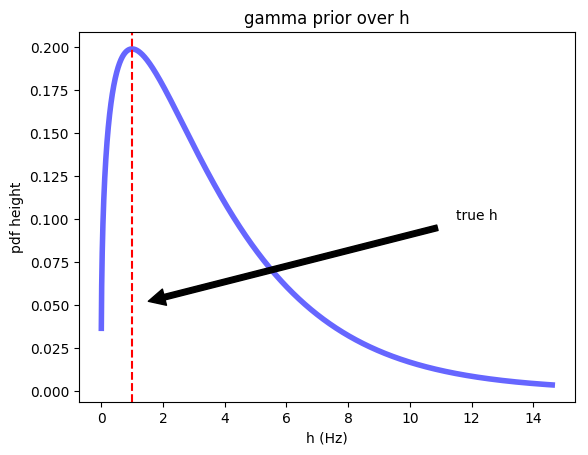

In [59]:
m, v, h = ww.result
#m = 1  # mode of gamma pdf
#v = 2 # var of gamma pdf
beta = m / (2 * v) + np.sqrt(m**2 / (v**2) + 4 / v) / 2  # 1 / scale parameter of gamma pdf
alpha = m * beta + 1   # shape parameter of gamma pdf
x = np.linspace(gamma.ppf(0.0001, alpha, scale = 1 / beta),gamma.ppf(0.99, alpha, scale = 1 / beta), 5000)
fig = plt.figure(1)
ax = fig.add_subplot(111)
y = gamma.pdf(x, alpha, scale = 1 / beta)
plt.plot(x, y,'b-', lw=4, alpha=0.6, label='gamma pdf')
plt.axvline(x=h, color='red', linestyle='--')
xlim = ax.get_xlim()
ax.annotate('true h', xy=(h, .25*y.max()), xytext=(.75*xlim[1], .5*y.max()),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.title('gamma prior over h')
plt.xlabel('h (Hz)')
plt.ylabel('pdf height')
plt.show()

In [60]:
# This cell is for using the shape and 1/scale parameters of the gamma prior directly
# def g(a=1.0, b=1.0):
#     return np.array([a, b])
# ww = interactive(g, a=(1,40), b=(1,40))
# display(ww)

## Choose ideal-observer's SNR

For now, I confound the SNR from the stimulus and the one internal to the observer. We have:$$SNR = \log \frac{\lambda_\text{high}}{\lambda_\text{low}}$$  
We impose the **constraint**: $\lambda_{\text{low}}+\lambda_\text{high}=40$ Hz

In [61]:
def f(SNR=2.946):
    return SNR
w = interactive(f, SNR=(0.01,50,0.01))
display(w)

In [62]:
SNR = w.result
rates_ratio = np.exp(SNR) 
rate_low = 40 / (rates_ratio + 1)
rate_high = rates_ratio * rate_low
print('lambda_low, lambda_high = ', str(round(rate_low,2)), str(round(rate_high,2)),'Hz')

lambda_low, lambda_high =  2.0 38.0 Hz


## Choose trial duration T (sec) and time discretization step dt (msec)

In [63]:
x_widget = widgets.IntSlider(min=1 , max=100, value=1)
y_widget = widgets.FloatSlider(min=0, max=8, value=1, step=x_widget.value / 100)

def update_y_step(*args):
    y_widget.step = x_widget.value
x_widget.observe(update_y_step, 'value')

def printer(dt, T):
    print(int(T*1000 / dt), ' observations per trial')
interact(printer, dt=x_widget, T=y_widget);

In [74]:
dt = x_widget.value / 1000.0
T = y_widget.value

## Choose number of trials to simulate

In [75]:
def jj(Trials=1):
    return Trials
xx = interactive(jj, Trials=(1,10000))
display(xx)

In [76]:
Trials = xx.result

## Select the outputs you are interested in
### Single-trial outputs

If you are planning to only simulate a single trial, choose the type of outputs that you want to display (plots)

In [77]:
def kk(envt=True, obs=True, LLR=True):
    return (envt, obs, LLR)
xxx = interactive(kk, envt=True, obs=True, LLR=True)
display(xxx)

In [78]:
envt, obs, LLR = xxx.result
singleTrialOutputs = np.array([envt, obs, LLR])
# print(singleTrialOutputs)

### Multi-trial outputs

In [79]:
def mm(raw_perf=True, perf_lastcp=True):
    return (raw_perf, perf_lastcp)
yyy = interactive(mm, raw_perf=True, perf_lastcp=True)
display(yyy)

In [80]:
raw_perf, perf_lastcp = yyy.result
multiTrialOutputs = np.array([raw_perf, perf_lastcp])
print(multiTrialOutputs)

[ True  True]


## Run simulations
### Recap of your parameters

In [81]:
print('{}\n\n\
{:24} {:>7}\n\
{:24} {:>7}\n\
{:24} {:>7}\n\
{:24} {:>7}\n\
{:24} {:>7} {:>7}\n\
{:24} {:>7}\n\
{:24} {:>7}\n\
{:24} {:>6}\n\
{:24} {:>7}'.format('To change any of these parameter values, use the sliders above and re-compute each cell',
                    'true h', h,
                    'gamma mode', m, 
                    'gamma variance', v, 
                    'SNR', SNR,
                    'click rates (Hz)', round(rate_low,2), round(rate_high,2),
                    'trial duration (sec)', T, 
                    'stimulus timestep (msec)', int(dt * 1000),
                    'nb observations per trial', int(T/dt),
                    'nb of trials to simulate', Trials))

To change any of these parameter values, use the sliders above and re-compute each cell

true h                       1.0
gamma mode                   1.0
gamma variance              10.0
SNR                        2.946
click rates (Hz)             2.0    38.0
trial duration (sec)        0.05
stimulus timestep (msec)       1
nb observations per trial     50
nb of trials to simulate       1


---
### Launch script

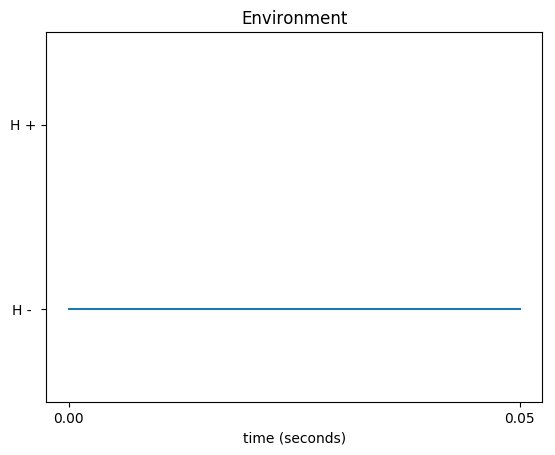

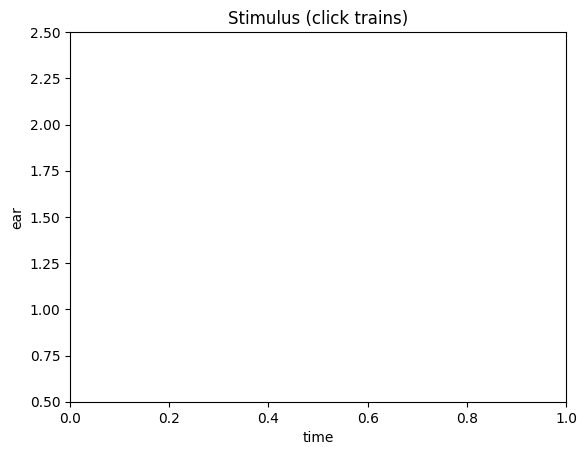

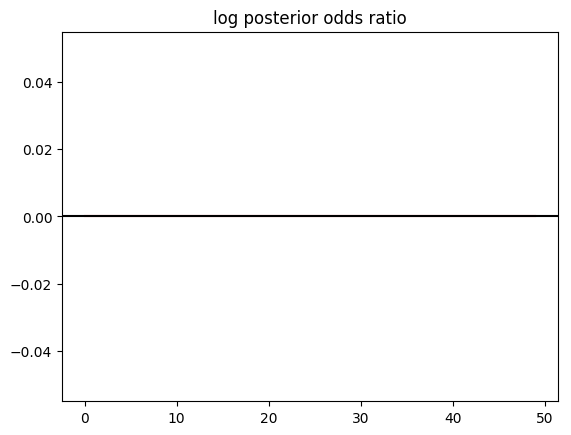

total elapsed time in hours:min:sec is 0:00:00


In [82]:
# np.random.seed(1)  # ensures each evaluation of the cell is independent of the previous ones
Expt = Experiment(setof_stim_noise=1, exp_dt=dt, setof_trial_dur=T, setof_h=h,
                  tot_trial=Trials, setof_low_high_rates = [rate_low, rate_high])
Observer = IdealObs(dt=Expt.exp_dt, expt=Expt, prior_h=np.array([alpha, beta]))
aa = datetime.datetime.now().replace(microsecond=0)
Expt.launch(Observer, singleTrialOutputs, multiTrialOutputs)
bb = datetime.datetime.now().replace(microsecond=0)
print('total elapsed time in hours:min:sec is', bb - aa)